In [1]:
!pip install obspy wget

In [2]:
import obspy
import numpy as np
import scipy
import pandas as pd
import h5py
from obspy.clients.fdsn.client import Client 
client= Client("IRIS")
from scipy.signal import decimate, butter,filtfilt
import matplotlib.pyplot as plt
import wget
import scipy.signal as signal
from obspy.geodetics.base import gps2dist_azimuth
from obspy.geodetics import locations2degrees
import matplotlib.dates as mdates

# datetime interaction
from datetime import datetime
from datetime import timedelta as dt
from obspy.core.utcdatetime import UTCDateTime

In [6]:
# read in data
df = pd.read_csv("C:/Users/wolfn/.seisbench/datasets/comcat/comcat_metadata.csv")
df2 = pd.read_csv("C:/Users/wolfn/.seisbench/datasets/comcat/miniPNW_metadata.csv")
df.shape

(183909, 36)

In [7]:
df['preferred_source_magnitude_type'].unique()

array(['md', 'ml', 'mh'], dtype=object)

In [12]:
f = h5py.File("C:/Users/wolfn/.seisbench/datasets/comcat/comcat_waveforms.hdf5", "r")
f2 = h5py.File("C:/Users/wolfn/.seisbench/datasets/comcat/miniPNw_waveforms.hdf5", "r")

In [13]:
def read_data(df: pd.DataFrame, index: int, apply_filter = None, freq = None, freqmax = None, freqmin = None):
    """
    This function taks in a dataframe and some index from that dataframe. Can add filters if desired. 
    Returns stream object, p-wave arrival time, s-wave arrival time, and distance between event and seismogram in km
    """
    # read in metadata
    source_id = df.iloc[index]['event_id']
    net = df.iloc[index]['station_network_code']
    sta = df.iloc[index]['station_code']
    loc =  df.iloc[index]['station_location_code']
    cha = df.iloc[index]['trace_channel'] # switched form station channel code -> trace_channel
    sample_p = df.iloc[index]['trace_P_arrival_sample']
    sample_s = df.iloc[index]['trace_S_arrival_sample']
    trace_starttime = df.iloc[index]['trace_start_time']
    sample_rate = df.iloc[index]['trace_sampling_rate_hz']


    # calculate the distance
    

    # station latitude and longitude
    slat = df.iloc[index]['station_latitude_deg']
    slon = df.iloc[index]['station_longitude_deg']


    # source latitude and longitude
    lat0 = df.iloc[index]['source_latitude_deg'] 
    lon0 = df.iloc[index]['source_longitude_deg']


    # Use Obspy.gps2dist_azimuth to calc great circle distance in meters, azimuth A->B in degrees, azimuth B->A in degrees
    dist,az,baz=gps2dist_azimuth(lat0,lon0,slat,slon)



    # read the data

    # Store trace name in tn so that we can use it to grab waveform from hdf5 file
    tn = df.iloc[index]['trace_name']
    bucket, narray = tn.split('$')
    x, y, z = iter([int(i) for i in narray.split(',:')])
    # print(x,y,z)
    data = f['/data/%s' % bucket][x, :y, :z]


    # Create stream object

    stream = obspy.Stream()


    for i in range(3):
        tr = obspy.Trace()
        tr.data = data[i, :]
        tr.stats.sampling_rate = df.iloc[index]['trace_sampling_rate_hz']
        tr.stats.starttime = datetime.utcfromtimestamp(UTCDateTime(trace_starttime).timestamp)
        tr.stats.station = sta
        tr.stats.network = net
        tr.stats.location = loc
        if i == 0:
          tr.stats.channel = cha+"E"
        elif i == 1:
          tr.stats.channel = cha+"N"
        else :
          tr.stats.channel = cha+"Z"
        stream.append(tr)

    if apply_filter == 'bandpass':
        stream.filter(apply_filter, freqmin = freqmin, freqmax = freqmax)
    elif apply_filter is not None:
        stream.filter(apply_filter, freq = freq)

    #Phase pick and arrival time info

    starttime = datetime.utcfromtimestamp(UTCDateTime(trace_starttime).timestamp)
    x = [starttime + dt(seconds = i/sample_rate) for i in np.arange(15001)]
    p_time = sample_p/sample_rate 
    s_time = sample_s/sample_rate


    return stream, p_time, s_time, dist/1000

In [14]:
tr, tp, ts, dist = read_data(df, 3)
print(tr[0].stats.starttime)
tp1 = UTCDateTime(tr[0].stats.starttime) + tp
print(tp1)

2002-10-03T01:55:59.530000Z
2002-10-03T01:56:53.950000Z


In [15]:
ps_ratio = np.zeros(183909)
ps_rat = pd.Series(ps_ratio)


In [1029]:
# from 0 - 183909 : 
for i in range(0,183909):
    # i = 0
    # read data, get stream object (tr), p-time (tp), s-time (ts), and dist btwn event and seismogram (dist)
    tr, tp, ts, dist = read_data(df, i)
    # print(tr[0].stats.starttime)
    tp1 = UTCDateTime(tr[0].stats.starttime) + tp
    ts1 = UTCDateTime(tr[0].stats.starttime) + ts

    station = df.iloc[i]['station_code']
    if df.iloc[i]["station_location_code"] == "--":
        thissta = df.iloc[i]["station_network_code"] + "."+ df.iloc[i]["station_code"] + ".." + df.iloc[i]["trace_channel"] + "Z"
    else:
        thissta = df.iloc[i]["station_network_code"] + "."+ df.iloc[i]["station_code"] + "."+df.iloc[i]["station_location_code"] + "." + df.iloc[i]["trace_channel"] + "Z"


    inv0 = client.get_stations(network = df.iloc[i]["station_network_code"], station = df.iloc[i]["station_code"], location = "*", channel = df.iloc[i]["trace_channel"] + "*", starttime = UTCDateTime(2002,1,1), endtime = UTCDateTime(2022,12,1), level = "response")


    # remove instrumental response
    PAZ = inv0.get_response(thissta, tr[0].stats.starttime).get_paz()
    paz_sta = {'gain': PAZ.stage_gain,
                'poles': PAZ.poles,
                'sensitivity': PAZ.normalization_factor*PAZ.stage_gain,
                'zeros': PAZ.zeros}
    tr.simulate(paz_remove = paz_sta, water_level = 10)

    # filter 1 - 20 hz ??? make sure this is part of our project
    tr.filter('bandpass',freqmin = 1,freqmax = 20,corners = 2,zerophase = True)  # will do 1 - 20 **********
    # calculate envelope using the obspy function of the vertical component, and then its log
    # data_envelope = np.log10(obspy.signal.filter.envelope(tr[2].data))
    tr2 = tr[2].copy()
    # tr2.data[:] = data_envelope

    # Calculate the time where the envelope hits 2 times the noise floor. This is our NOISE VALUE to remove from P and S 

    noise = tr.copy()
    noise.trim(tp1 - 12, tp1 - 2)  
    noise_value = np.sum(noise[0].data**2 + noise[1].data**2 + noise[2].data**2)


    # Calculate the P-wave values

    wave_p = tr.copy()
    wave_p.trim(tp1 - 2, tp1 + 8)  
    wavep_value = np.sum(wave_p[0].data**2 + wave_p[1].data**2 + wave_p[2].data**2)

    # Calculate the S-wave values

    wave_s = tr.copy()
    wave_s.trim(ts1 - 2, ts1 + 8)  
    wave_s_value = np.sum(wave_s[0].data**2 + wave_s[1].data**2 + wave_s[2].data**2)

    # Put it all together- Calculate the P/S ratio
    # need to create new series with all newly calculated ps ratios. append to end of df

    ps_rat[i] = np.sqrt(wavep_value - noise_value) / np.sqrt( wave_s_value - noise_value)
    # print("Source type: ", df['source_type'][i], "P/S ratio:", ps_ratio[i])



c:\Users\wolfn\anaconda3\envs\PNSN\lib\site-packages\obspy\core\inventory\response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
  warnings.warn(msg)
c:\Users\wolfn\anaconda3\envs\PNSN\lib\site-packages\obspy\core\inventory\response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
  warnings.warn(msg)
c:\Users\wolfn\anaconda3\envs\PNSN\lib\site-packages\obspy\core\inventory\response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
  warnings.warn(msg)
c:\Users\wolfn\anaconda3\envs\PNSN\lib\site-packages\obspy\core\inventory\response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
  warnings.warn(msg)
c:\Users\wolfn\anaconda3\envs\PNSN\lib\site-packages\obspy\core\inventory\response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
 

In [1046]:
print(ps_rat[183460])

0.6275066918243879


In [1056]:
# list of indices where we ran into an error
fail_list = [112289,114255,140476,140482,156214,156583,156763,156848,157130,157207,157440,157700,161960,166096,166192,166245,166313,166618,167685,167804,168620,171893]
ps_ratio = ps_rat
num_nans = ps_rat.isna().sum()
num_zeros= (ps_rat == 0).sum()
print("# NaNs:", num_nans, "\n", "# zeros:", num_zeros, "\n")

# NaNs: 1593 
 # zeros: 22 



In [1070]:
final_df = pd.concat([df, ps_ratio], axis=1) 
final_df = final_df.rename(columns={0: 'ps_ratio'})
cleaned_df = final_df.dropna(subset=['ps_ratio', 'source_local_magnitude', 'source_duration_magnitude'])
print(cleaned_df.shape, '\n', list(cleaned_df.keys()))

(147787, 37) 
 ['event_id', 'source_origin_time', 'source_latitude_deg', 'source_longitude_deg', 'source_type', 'source_depth_km', 'preferred_source_magnitude', 'preferred_source_magnitude_type', 'preferred_source_magnitude_uncertainty', 'source_depth_uncertainty_km', 'source_horizontal_uncertainty_km', 'station_network_code', 'trace_channel', 'station_code', 'station_location_code', 'station_latitude_deg', 'station_longitude_deg', 'station_elevation_m', 'trace_name', 'trace_sampling_rate_hz', 'trace_start_time', 'trace_S_arrival_sample', 'trace_P_arrival_sample', 'trace_S_arrival_uncertainty_s', 'trace_P_arrival_uncertainty_s', 'trace_P_polarity', 'trace_S_onset', 'trace_P_onset', 'trace_snr_db', 'year', 'source_type_pnsn_label', 'source_local_magnitude', 'source_local_magnitude_uncertainty', 'source_duration_magnitude', 'source_duration_magnitude_uncertainty', 'source_hand_magnitude', 'ps_ratio']


In [1076]:
print(type(cleaned_df['source_latitude_deg'].values))

<class 'numpy.ndarray'>


In [1080]:
# 3 arrays : ps ratio, eventid, list of unique event id
# Take the median of all ps ratios for each uniqe event id
event_ps = cleaned_df.groupby('event_id')['ps_ratio'].median()
event_dmag = cleaned_df.groupby('event_id')['source_duration_magnitude'].mean()
event_lmag = cleaned_df.groupby('event_id')['source_local_magnitude'].mean()

data = {
    'event_id': event_ps.index,
    'ps_ratio': event_ps.values,
    'duration_magnitude': event_dmag.values,
    'local_magnitude': event_lmag.values
}

MLdf = pd.DataFrame(data)
MLdf['Ml_minus_Md'] = MLdf['local_magnitude'] - MLdf['duration_magnitude']

MLdf = pd.merge(MLdf, df[['event_id', 'source_type', 'source_latitude_deg', 'source_longitude_deg']], on='event_id', how='left')

print(MLdf.keys())


     event_id  ps_ratio  duration_magnitude  local_magnitude  Ml_minus_Md  \
0  uw10552668  1.218720                2.47             2.93         0.46   
1  uw10556918  0.877235                2.74             2.96         0.22   
2  uw10568613  0.284936                1.57             1.96         0.39   
3  uw10574613  0.997252                0.42             0.42         0.00   
4  uw10574613  0.997252                0.42             0.42         0.00   

  source_type  source_latitude_deg  source_longitude_deg  
0  earthquake               48.968              -123.066  
1  earthquake               47.916              -124.300  
2   explosion               45.814              -123.304  
3  earthquake               46.179              -122.107  
4  earthquake               46.179              -122.107  


In [1081]:
print(list(MLdf.keys()))

['event_id', 'ps_ratio', 'duration_magnitude', 'local_magnitude', 'Ml_minus_Md', 'source_type', 'source_latitude_deg', 'source_longitude_deg']


## Calculating Duration Magnitude

Comparison with a coda duration magnitude. First, we will plot the data in log(amp) to see noise levels and coda amplitude decay.


We will follow a similar process that the University of Utah to calculate the duration magnitude (Koper et al., 2021) and some of the notes from the PNSN process.

The workflow to measure duration may be as follow:

1. Select all vertical seismograms all channels
2. remove instrumental response to ground velocity in m/s
3. filter the data wth a 4th pole butterworth bandpass between 1 and 10 Hz.
4. take the envelope of the seismograms ($\sqrt{ x^2(t) + H(x(t))^2}$)
5. take the $log_{10}$ of the envelope.
6. $t_P$ is the P-wave arrival time.
7. $t_S$ is the S-wave arrival time.
8. $t_{peak}$ is the time of maximum amplitude after the S.
9. the noise is the average value of the envelope in a 10 s window starting 12 s before the theoretical P-wave arrival time (tP).
10. the duration $T_D = t_3-t_{peak}$ 
11. calculate the moment duration using the equation: $M_D = -1.61 + 2.82*log10(T_D)$ , where $\Delta$ is the source receiver distance. $M_d$ is taken as the median of at least 3 station-estimates. 
# NEED TO REWORK $M_D$ to find new coefficients to replace  -1.61 and 2.82 parameter
# Note: The code below is work done by Nicholas Wolf and Marine Denolle in an attempt to recalculate duration magnitudes within the PNSN network. In the past year, Yiyu Ni found bias within the calculated duration magnitudes for the PNSN system. Our goal was to recalculate these duration magnitudes and at ultimately have a cohesive new calculation of duration magnitudes with hopes of removing that bias. This part of the project hit a snag and we were not able to make the proper calculations within the timeframe that we had. Feel free to look over the code below as this is our attempt to recalcalte the duration magnitude. Be aware that the code does not have the desired output though. 

In [1016]:

# let's select a station
# import time as time
md_true=np.zeros(183909)
log_Td = np.zeros(183909)



for i in range(0,200):
  tr, tp, ts, dist = read_data(df, i)

  tp1 = UTCDateTime(tr[0].stats.starttime) + tp
  ts1 = UTCDateTime(tr[0].stats.starttime) + ts
  

  # remove the instrumental zone and convolve with wood anderson
  station = df.iloc[i]["station_code"]
  if df.iloc[i]["station_location_code"] == "--":
    thissta = df.iloc[i]["station_network_code"] + "." + df.iloc[i]["station_code"] + ".." + df.iloc[i]['trace_channel'] + "Z"
  else:
    thissta = df.iloc[i]["station_network_code"] + "." + df.iloc[i]["station_code"] + "." + df.iloc[i]["station_location_code"] + "." + df.iloc[i]['trace_channel']+"Z"

  inv0 = client.get_stations(network = df.iloc[i]["station_network_code"],\
                              station = df.iloc[i]["station_code"],\
                              location = "*",\
                              channel = df.iloc[i]['trace_channel']+"*",\
                            starttime = UTCDateTime(2002,1,1),endtime=UTCDateTime(2022,12,1),level="response")
  # remove response
  PAZ = inv0.get_response(thissta,tr[0].stats.starttime).get_paz()
  paz_sta = {'gain': PAZ.stage_gain,
              'poles': PAZ.poles,
              'sensitivity': PAZ.normalization_factor*PAZ.stage_gain,
              'zeros': PAZ.zeros}
  tr.simulate(paz_remove=paz_sta, water_level=10)
  # filter 1-10Hz
  tr.filter('bandpass',freqmin=1,freqmax=10,corners=2,zerophase=True)  # will do 1 - 20 **********
  # calculate envelope using the obspy function of the vertical component, and then its log
  data_envelope = obspy.signal.filter.envelope(tr[2].data)
  tr2 = tr[2].copy()
  tr2.data[:]=np.log10(data_envelope)

  # calculate the time at which the envelope hits 2 times the noise floor
  noise = tr.copy()
  noise[0].data = data_envelope
  noise.trim(tp1 - 12,tp1 - 2)  
  nnoise_value = np.sum(noise[2].data**2)  # This is our noise value
  # noise[0].data**2 + noise[1].data**2 
  # fig=plt.figure()
  # plt.plot(tr2.data)
  # wave_p = tr.copy()
  # wave_p.trim(tp1 - 2,tp1 + 8)  
  # wavep_value = np.sum(wave_p[0].data**2 + wave_p[1].data**2 + wave_p[2].data**2)
  # wave_s = tr.copy()
  # wave_s.trim(ts1 - 2, ts1 + 8)  
  # wave_s_value = np.sum(wave_s[0].data**2 + wave_s[1].data**2 + wave_s[2].data**2)


  # ps_ratio = np.sqrt(wavep_value - nnoise_value) / np.sqrt( wave_s_value - nnoise_value)  #### this is our p/s ratio 
  # # time of pick

  wave = tr2.copy()
  wave = tr2.trim(tr2.stats.starttime + tp, tr2.stats.starttime + tp + ts + 30)
  
  # get the first element of the time series where the envelope is 

  # plt.plot(tr2.data-np.log10(2*10**nnoise_value),'r');plt.grid(True)
  # print(nnoise_value,tr.stats,len(wave[0].data))
  # print(len(wave.data[wave.data>=np.log10(2*10**nnoise_value)]))
  Td = len(wave.data[wave.data >= np.log10(2*nnoise_value)]) / tr2.stats.sampling_rate #duration
  # print("Td:", Td,  )
  log_Td[i] = np.log10(Td)

  md_true[i]=df.iloc[i]["source_duration_magnitude"]

# Need to solve for new coefficients in --> MD = a + b*log10(Td)
# Will have many MD's (y value) and Td's (x value) 
# Use stats.linregress to find new coefficients a and b. b will be slope, a will be intercept 
# Log_Td vs md_true

c:\Users\wolfn\anaconda3\envs\PNSN\lib\site-packages\obspy\core\inventory\response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
  warnings.warn(msg)
c:\Users\wolfn\anaconda3\envs\PNSN\lib\site-packages\obspy\core\inventory\response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
  warnings.warn(msg)
c:\Users\wolfn\anaconda3\envs\PNSN\lib\site-packages\obspy\core\inventory\response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
  warnings.warn(msg)
c:\Users\wolfn\anaconda3\envs\PNSN\lib\site-packages\obspy\core\inventory\response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
  warnings.warn(msg)
c:\Users\wolfn\anaconda3\envs\PNSN\lib\site-packages\obspy\core\inventory\response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
 

In [1091]:
!pip install geopandas

Now we will use Decision Trees classification to see if we can use some of our features to predict if a given event is an explosion or an earthquake

In [1094]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Assuming you have a DataFrame named MLdf with the specified columns

# Separate the features and the target variable
features = MLdf[['ps_ratio', 'duration_magnitude', 'local_magnitude', 'Ml_minus_Md', 'source_latitude_deg', 'source_longitude_deg']]
target = MLdf['source_type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

# Decision Tree classifier using individual features

for feature in features.columns:
    X_train_feature = X_train[[feature]]
    X_test_feature = X_test[[feature]]
    
    decision_tree = DecisionTreeClassifier(random_state=0)
    decision_tree.fit(X_train_feature, y_train)
    
    y_pred = decision_tree.predict(X_test_feature)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy with feature", feature, ":", accuracy)

# Decision Tree classifier using all features

decision_tree_all = DecisionTreeClassifier(random_state=0)
decision_tree_all.fit(X_train, y_train)

y_pred_all = decision_tree_all.predict(X_test)
accuracy_all = accuracy_score(y_test, y_pred_all)
print("Accuracy with all features:", accuracy_all)

Accuracy with feature ps_ratio : 0.9865273484746674
Accuracy with feature duration_magnitude : 0.9141244456390271
Accuracy with feature local_magnitude : 0.9140908480043005
Accuracy with feature Ml_minus_Md : 0.9141244456390271
Accuracy with all features: 0.9898535143125924


Accuracy: 0.995766698024459


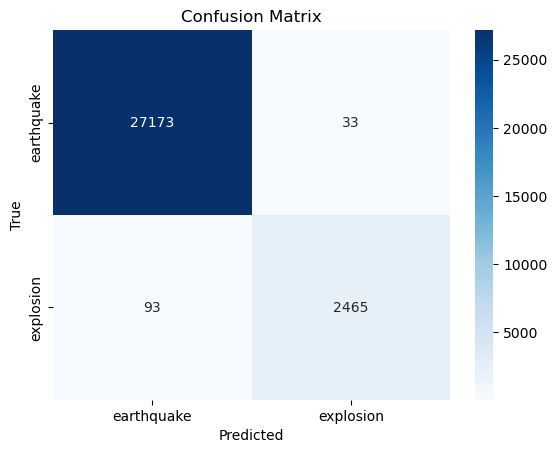

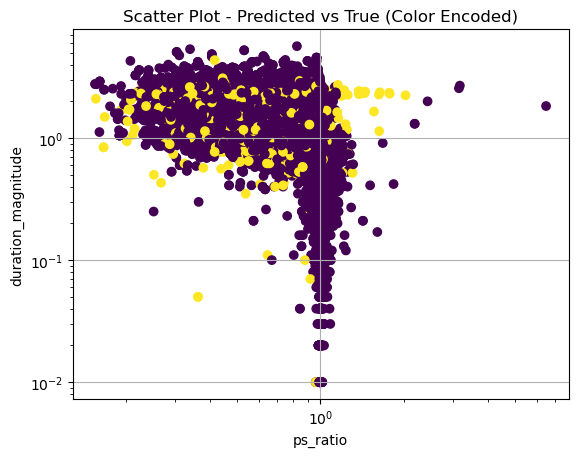

<AxesSubplot: >

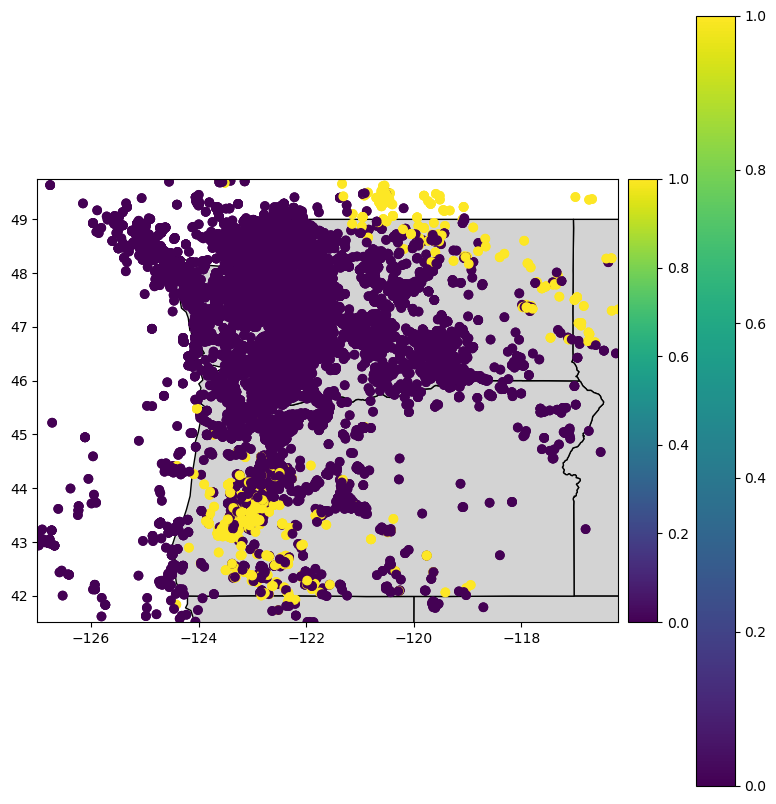

In [1134]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# Load the shapefile of Washington State
wa_shapefile = "C:/Users/wolfn/Downloads/States_shapefile/States_shapefile.shp"
wa_map = gpd.read_file(wa_shapefile)


# Separate the features and the target variable
features = MLdf[['ps_ratio', 'duration_magnitude', 'local_magnitude', 'Ml_minus_Md', 'source_latitude_deg', 'source_longitude_deg']]
target = MLdf['source_type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

# Decision Tree classifier using all features
decision_tree = DecisionTreeClassifier(random_state=0)
decision_tree.fit(X_train, y_train)

# Predict the target variable on the test set
y_pred = decision_tree.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Create a confusion matrix
labels = ['earthquake', 'explosion']
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - DTC')
plt.show()

# Create a scatter plot of the predicted vs true values
le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test)
y_pred_encoded = le.transform(y_pred)

plt.scatter(X_test['ps_ratio'], X_test['duration_magnitude'], c=y_pred_encoded, cmap='viridis')
plt.xscale('log')  # Scale x-axis to log values
plt.yscale('log')  # Scale y-axis to log values
plt.xlabel('ps_ratio')
plt.ylabel('duration_magnitude')
plt.grid(True)
plt.title('Scatter Plot - Predicted vs True (Color Encoded) - DTC')
plt.show()

# Create a geospatial map
geometry = gpd.points_from_xy(X_test['source_longitude_deg'], X_test['source_latitude_deg'])
gdf = gpd.GeoDataFrame(X_test, geometry=geometry)
gdf['predicted_labels'] = y_pred_labels

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the basemap of Washington State
wa_map.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot the data points
gdf.plot(ax=ax, column=gdf['predicted_labels'], legend=True)

# Set plot limits
ax.set_xlim(gdf['source_longitude_deg'].min(), gdf['source_longitude_deg'].max())
ax.set_ylim(gdf['source_latitude_deg'].min(), gdf['source_latitude_deg'].max())

# Create a colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
gdf.plot(ax=ax, column=gdf['predicted_labels'], legend=True, cax=cax)

And we can compare this to a Deep Neural Network (DNN) to see how this performs as well. 

In [1136]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf


# Assuming you have a DataFrame named MLdf with the specified columns

# Separate the features and the target variable
features = MLdf[['ps_ratio', 'duration_magnitude', 'local_magnitude', 'Ml_minus_Md', 'source_latitude_deg', 'source_longitude_deg']]
target = MLdf['source_type']

# Convert target labels to numerical values
le = LabelEncoder()
target_encoded = le.fit_transform(target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target_encoded, test_size=0.2, random_state=0)

# Create a deep neural network model using Keras
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(6,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Predict the target variable on the test set
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int).reshape(-1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_labels)
print("Accuracy:", accuracy)


Epoch 1/10
2977/2977 [==============================] - 6s 2ms/step - loss: 0.3244 - accuracy: 0.9100 - val_loss: 0.2581 - val_accuracy: 0.9150
Epoch 2/10
2977/2977 [==============================] - 6s 2ms/step - loss: 0.2702 - accuracy: 0.9113 - val_loss: 0.2629 - val_accuracy: 0.9150
Epoch 3/10
2977/2977 [==============================] - 5s 2ms/step - loss: 0.2563 - accuracy: 0.9109 - val_loss: 0.2414 - val_accuracy: 0.9144
Epoch 4/10
2977/2977 [==============================] - 5s 2ms/step - loss: 0.2491 - accuracy: 0.9117 - val_loss: 0.2376 - val_accuracy: 0.9166
Epoch 5/10
2977/2977 [==============================] - 5s 2ms/step - loss: 0.2418 - accuracy: 0.9128 - val_loss: 0.2441 - val_accuracy: 0.9194
Epoch 6/10
2977/2977 [==============================] - 5s 2ms/step - loss: 0.2330 - accuracy: 0.9167 - val_loss: 0.2245 - val_accuracy: 0.9228
Epoch 7/10
2977/2977 [==============================] - 5s 2ms/step - loss: 0.2279 - accuracy: 0.9192 - val_loss: 0.2376 - val_accuracy:

In [1126]:
print(MLdf.keys())

Index(['event_id', 'ps_ratio', 'duration_magnitude', 'local_magnitude',
       'Ml_minus_Md', 'source_type', 'source_latitude_deg',
       'source_longitude_deg'],
      dtype='object')


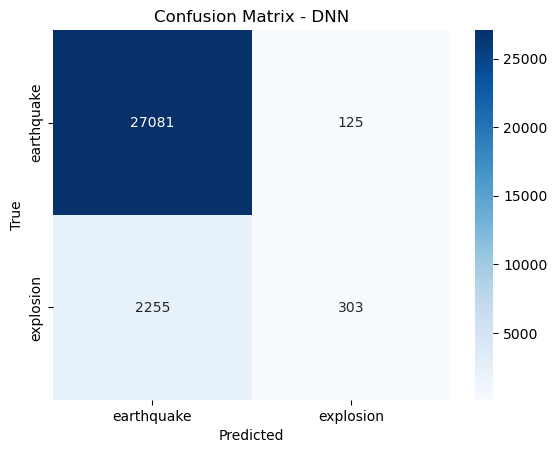

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


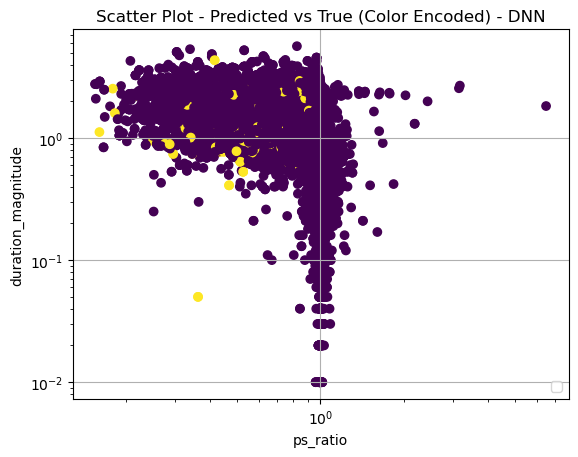

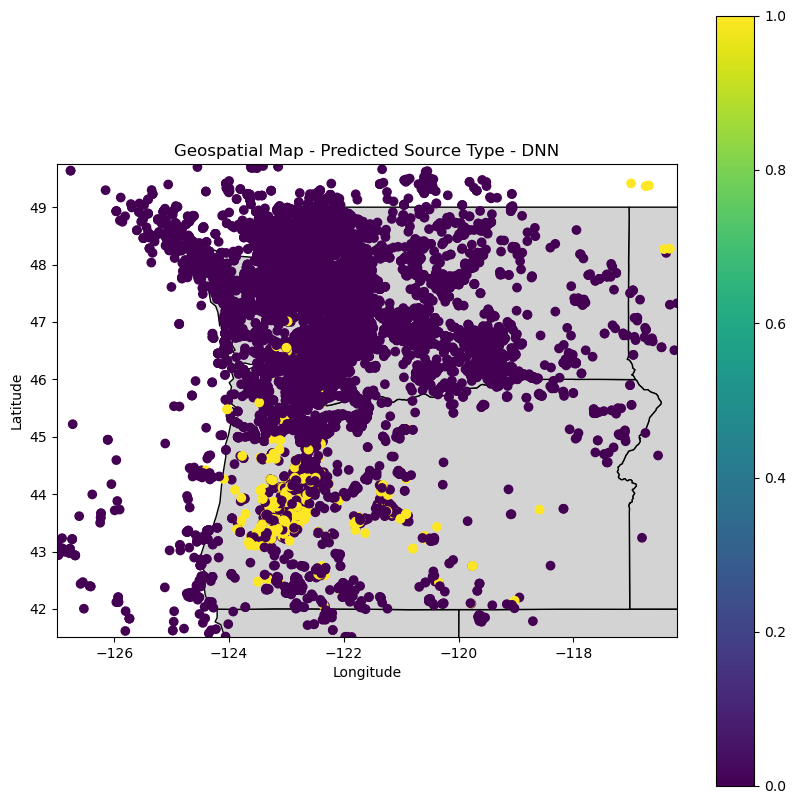

In [1141]:

labels = ['earthquake', 'explosion']
cm = confusion_matrix(y_test, y_pred_labels)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - DNN')
plt.show()

# Create a scatter plot of the predicted vs true values
plt.scatter(X_test['ps_ratio'], X_test['duration_magnitude'], c=y_pred_labels, cmap='viridis')
plt.xscale('log')  # Scale x-axis to log values
plt.yscale('log')  # Scale y-axis to log values
plt.xlabel('ps_ratio')
plt.ylabel('duration_magnitude')
plt.legend(loc='lower right')
plt.grid(True)
plt.title('Scatter Plot - Predicted vs True (Color Encoded) - DNN')
plt.show()

# Create a geospatial map
geometry = gpd.points_from_xy(X_test['source_longitude_deg'], X_test['source_latitude_deg'])
gdf = gpd.GeoDataFrame(X_test, geometry=geometry)
gdf['predicted_labels'] = y_pred_labels



fig, ax = plt.subplots(figsize=(10, 10))

# Load the shapefile of Washington State
wa_shapefile = "C:/Users/wolfn/Downloads/States_shapefile/States_shapefile.shp"
wa_map = gpd.read_file(wa_shapefile)

# Plot the basemap of Washington State
wa_map.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot the data points
gdf.plot(ax=ax, column=gdf['predicted_labels'], legend=True)

# Set plot limits based on the data points
ax.set_xlim(gdf['source_longitude_deg'].min(), gdf['source_longitude_deg'].max())
ax.set_ylim(gdf['source_latitude_deg'].min(), gdf['source_latitude_deg'].max())

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Geospatial Map - Predicted Source Type - DNN')
plt.show()